In [15]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%qtconsole

## Purpose

The purpose of this notebook is to figure out how to compute the power spectra and connectivity measures over an entire session. This will be used as a baseline to compare SWR-triggered power spectrograms and connectivity measures.
See:

> Carr, M.F., Karlsson, M.P., and Frank, L.M. (2012). Transient Slow Gamma Synchrony Underlies Hippocampal Memory Replay. Neuron 75, 700–713.


In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import xarray as xr

In [17]:
from src.analysis import (decode_ripple_clusterless,
                          detect_epoch_ripples,
                          ripple_triggered_connectivity,
                          connectivity_by_ripple_type)
from src.data_processing import (get_LFP_dataframe, make_tetrode_dataframe)
from src.parameters import (ANIMALS, SAMPLING_FREQUENCY,
                            MULTITAPER_PARAMETERS, FREQUENCY_BANDS,
                            RIPPLE_COVARIATES)

/Users/edeno/anaconda3/envs/Jadhav-2016-Data-Analysis/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [18]:
epoch_key = ('HPa', 6, 2)

In [19]:
tetrode_info = make_tetrode_dataframe(ANIMALS)[epoch_key]
tetrode_info = tetrode_info[
    ~tetrode_info.descrip.str.endswith('Ref').fillna(False)]

lfps = pd.Panel(
    {tetrode_key: get_LFP_dataframe(tetrode_key, ANIMALS)
     for tetrode_key in tetrode_info.index})

blah = xr.DataArray(
    pd.concat({tetrode_key: get_LFP_dataframe(tetrode_key, ANIMALS)
               for tetrode_key in tetrode_info.index}, axis=1),
    dims=['time', 'tetrode_id'],
    name='electric_potential')
blah['tetrode_id'] = tetrode_info.tetrode_id.values

## Matching the frequency resolution

Given an existing set of multitaper parameters for creating a spectrogram (or connectivity-ogram) around the ripple onset, we want to match the frequency resolution of those parameters when computing the spectra (or connectivity measure) over the entire session as baseline.

We get the half-bandwidth frequency by dividing out the time in the time-half bandwidth product. We then use this to compute a new time-halfbandwidth product using the time for entire session.

In [20]:
from src.spectral.connectivity import Connectivity
from src.spectral.transforms import Multitaper

parameters = MULTITAPER_PARAMETERS['4Hz_Resolution']
total_time = lfps.major_axis.max() - lfps.major_axis.min()
desired_half_bandwidth = parameters['time_halfbandwidth_product'] / parameters['time_window_duration']
time_halfbandwidth_product = total_time * desired_half_bandwidth

print('old time-half bandwidth product: {0}'.format(parameters['time_halfbandwidth_product']))
print('desired half bandwidth frequency resolution: {0} Hz'.format(desired_half_bandwidth))
print('total time: {0} seconds'.format(total_time))
print('new time-half bandwidth product: {0}'.format(time_halfbandwidth_product))

old time-half bandwidth product: 1
desired half bandwidth frequency resolution: 4.0 Hz
total time: 1205.0266666666666 seconds
new time-half bandwidth product: 4820.106666666667


Since we are computing the Fourier transform over the entire session, we have 1807541 time samples, meaning we have 1822500 independent estimates of frequencies in the frequency domain. Each of these independent estimates will have higher variance, but using multitapers can help smooth these estimates.

A rule of thumb for the maximum number of tapers is 2 * `time_halfbandwidth_product` - 1.
Because we are trying to match a 4 Hz frequency resolution, our `time_halfbandwidth_product` is large and this rule of thumb implies `n_tapers` = 9639 and computationally, this would take a long time. So we need to figure out what a reasonable number of tapers is that balances both our need to smooth the large number of independent estimates and computational capabilities.



Multitaper(sampling_frequency=1500, time_halfbandwidth_product=4820.1066666666666, time_window_duration=1205.0273333333334, time_window_step=1205.0273333333334, detrend_type='constant', start_time=4122.992, n_tapers=1)
Multitaper(sampling_frequency=1500, time_halfbandwidth_product=4820.1066666666666, time_window_duration=1205.0273333333334, time_window_step=1205.0273333333334, detrend_type='constant', start_time=4122.992, n_tapers=2)
Multitaper(sampling_frequency=1500, time_halfbandwidth_product=4820.1066666666666, time_window_duration=1205.0273333333334, time_window_step=1205.0273333333334, detrend_type='constant', start_time=4122.992, n_tapers=3)


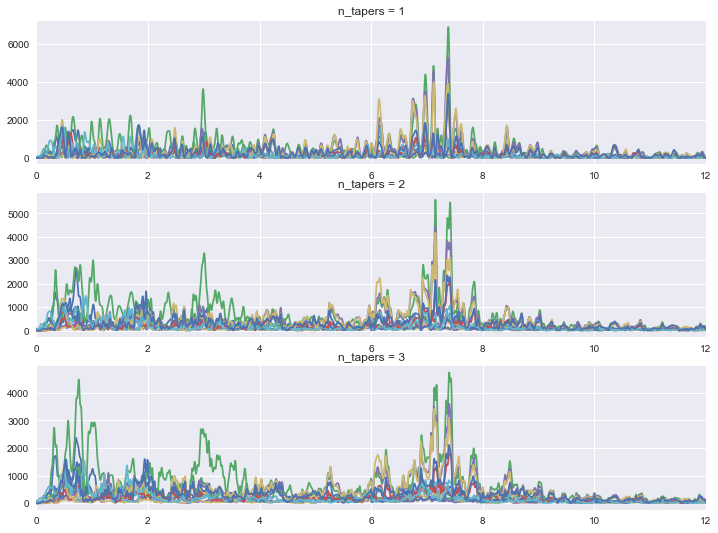

In [7]:
fig, axes = plt.subplots(3, 1, figsize=(12,9));

for n_tapers, ax in zip(np.arange(1, 4), axes):
    m = Multitaper(
            lfps.values.squeeze().T,
            sampling_frequency=SAMPLING_FREQUENCY,
            time_halfbandwidth_product=time_halfbandwidth_product,
            n_tapers=n_tapers,
            start_time=lfps.major_axis.min())
    c = Connectivity.from_multitaper(m)

    ax.plot(c.frequencies, c.power()[..., (tetrode_info.area.isin(['CA1', 'iCA1'])).values].squeeze())
    ax.set_xlim((0, 12));
    ax.set_title('n_tapers = {0}'.format(n_tapers));

Another issue is computing the cross spectral density matrix. Since we have 1822500 and 19 signals, we have to compute a 19 x 19 matrix for each frequency. This not only takes a long time to compute, but also takes up a huge amount of memory. We could take fewer fft samples, but this just truncates the time series:

Multitaper(sampling_frequency=1500, time_halfbandwidth_product=4820.1066666666666, time_window_duration=1205.0273333333334, time_window_step=1205.0273333333334, detrend_type='constant', start_time=4122.992, n_tapers=3)


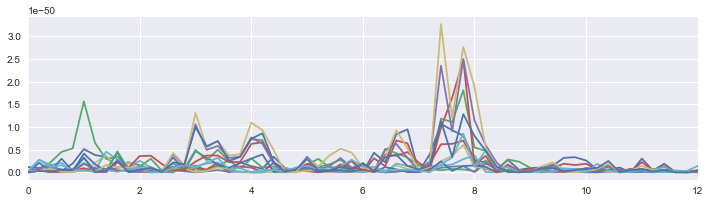

In [8]:
plt.figure(figsize=(12, 3))
m = Multitaper(
        lfps.values.squeeze().T,
        sampling_frequency=SAMPLING_FREQUENCY,
        time_halfbandwidth_product=time_halfbandwidth_product,
        n_tapers=3,
        n_fft_samples=5 * SAMPLING_FREQUENCY,
        start_time=lfps.major_axis.min())
c = Connectivity.from_multitaper(m)
plt.plot(c.frequencies, c.power()[..., (tetrode_info.area.isin(['CA1', 'iCA1'])).values].squeeze())
plt.xlim((0, 12));

We could break the time series into shorter time windows and average over the windows, but then we suffer the effect of windowing. Also for certain parameters, we have the same problem of too many tapers if we use the rule 2 * `time_halfbandwidth` - 1 to get the `n_tapers`.

Multitaper(sampling_frequency=1500, time_halfbandwidth_product=2.0, time_window_duration=0.5, time_window_step=0.5, detrend_type='constant', start_time=4122.992, n_tapers=3)


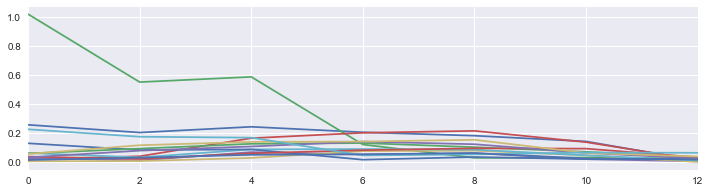

In [41]:
time_window_duration = 0.5 # seconds
desired_half_bandwidth = parameters['time_halfbandwidth_product'] / parameters['time_window_duration']
time_halfbandwidth_product = time_window_duration * desired_half_bandwidth


plt.figure(figsize=(12, 3))
m = Multitaper(
    lfps.values.squeeze().T,
    sampling_frequency=parameters['sampling_frequency'],
    time_halfbandwidth_product=time_halfbandwidth_product,
    time_window_duration=time_window_duration,
    n_tapers=3,
    start_time=lfps.major_axis.min())


c = Connectivity(
    fourier_coefficients=np.mean(m.fft(), axis=0, keepdims=True),
    frequencies=m.frequencies,
    time=lfps.major_axis.min())

plt.plot(c.frequencies, c.power()[..., (tetrode_info.area.isin(['CA1', 'iCA1'])).values].mean(axis=0))
plt.xlim((0, 12));

There is also the problem of matching the number of frequencies. Maybe it's just better to use the same parameters as the ripple-locked and then average?

In [ ]:
params = deepcopy(parameters)
params.pop('window_of_interest')
m = Multitaper(
    lfps.values.squeeze().T,
    **params,
    start_time=lfps.major_axis.min())
c = Connectivity.from_multitaper(m)